https://arxiv.org/abs/2408.00888

https://arxiv.org/abs/1802.10174

https://arxiv.org/abs/2212.04400

https://cedric.cnam.fr/~soutif/QKP/format.html

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import yfinance as yf

import scipy
import cvxpy as cp

In [4]:
def covariance(samples):
    mean_zero_samples = samples - samples.mean(axis=0)[None, :]
    C = (mean_zero_samples[:, :, None] * mean_zero_samples[:, None, :]).mean(axis=0)
    return C

In [5]:
def sigmoid(x):
    out = 0 * x
    mask = x > 0
    
    exp_neg_x = np.exp(-x[mask])
    out[mask] = 1 / (1 + exp_neg_x)
    
    exp_x = np.exp(x[~mask])
    out[~mask] = exp_x / (1 + exp_x)
    
    return out

In [348]:
dim = 5
Q = np.array([
    [8, 2, 3, 4, 5],
    [2, 7, 2, 3, 4],
    [3, 2, 6, 2, 3],
    [4, 3, 2, 5, 2],
    [5, 4, 3, 2, 9]
])
weights = np.array([2, 3, 4, 5, 9])
capacity = 10

normalized_weights = weights / capacity

In [349]:
raw_potential = lambda x: -np.einsum('ni,ij,nj->n', x, Q, x)
raw_isvalid = lambda x: (x @ normalized_weights <= 1) * (x >= 0).all(axis=-1)

In [350]:
def mirror_map(x):
    assert len(x.shape) == 2, 'Input must be 2 dimensional'
    z = sigmoid(x)
    # a = np.max(x, axis=-1)
    # exp_x = np.exp(x - a[:, None])
    # z = exp_x / (np.exp(-a) + exp_x @ normalized_weights)[:, None]
    return z

In [351]:
def potential(x):
    z = mirror_map(x)
    return raw_potential(z)

def isvalid(x):
    z = mirror_map(x)
    return raw_isvalid(np.round(z))

In [352]:
particle_filter_samples = 100
particle = np.zeros(dim)

In [353]:
working_gamma = 0.1

In [354]:
log_w = np.zeros(particle_filter_samples)
for i in range(10):
    noise = np.random.normal(0, 1, (particle_filter_samples, dim))
    samples = particle[None, :] + working_gamma * noise

    valid_samples = isvalid(samples)
    invalid_samples = ~valid_samples
    
    log_w[valid_samples] = -potential(samples[valid_samples])
    log_w[invalid_samples] = log_w[valid_samples].min()

    w = np.exp(log_w - log_w.max())
    w[invalid_samples] = 0
    w /= w.sum()
    
    particle += w @ (samples - particle[None, :])
    
    print(potential(particle.reshape(1, -1)))

[-23.53804468]
[-23.73005593]
[-24.01340585]
[-24.87754576]
[-25.54765684]
[-25.95421338]
[-26.43262792]
[-27.17556323]
[-28.06696294]
[-28.33720824]


In [355]:
z = mirror_map(particle.reshape(1, -1))
z = np.round(z)
z @ weights

array([10.])

In [356]:
raw_potential(z)

array([-38.])

In [357]:
z

array([[1., 1., 0., 1., 0.]])

In [358]:
capacity

10

In [359]:
z

array([[1., 1., 0., 1., 0.]])

# HARD

In [425]:
with open('jeu_100_50_3.txt', 'r') as f:
    lines = f.read().split('\n')

In [426]:
dim = int(lines[1])
diag = np.array([int(x) for x in lines[2].split()])

In [427]:
off_diag = []

for i in range(3, dim + 3 - 1):
    off_diag.append(np.array([int(x) for x in lines[i].split()]))

In [428]:
constraint_type = int(lines[dim + 3])
# 0 if the constraint is of type <= (i.e. always since we are considering (QKP) instances)
# and 1 if the constraint is an eglity constraint
print(constraint_type) 

0


In [429]:
capacity = int(lines[dim + 3 + 1])
capacity

156

In [430]:
weights = np.array([int(x) for x in lines[dim + 3 + 2].split()])

In [431]:
A = np.zeros((dim, dim))
for i in range(dim):
    A[i, i] = diag[i] / 2
    if i < dim - 1:
        A[i, i+1:] = off_diag[i] / 2
        
A += A.T

In [432]:
normalized_weights = weights / capacity

In [433]:
raw_potential = lambda x: -np.einsum('ni,ij,nj->n', x, A, x)
raw_isvalid = lambda x: (x >= 0).all(axis=-1) * (x @ normalized_weights <= 1)

In [434]:
def potential(x):
    z = mirror_map(x)
    return raw_potential(np.round(z))

def isvalid(x):
    z = mirror_map(x)
    return raw_isvalid(np.round(z))

In [435]:
particle_filter_samples = 100
particle = np.zeros(dim)

In [436]:
np.random.choice(range(dim), 5, replace=False)

array([77,  6, 73,  1,  8])

In [447]:
working_gamma = 0.001
num_iters = 1000
invalid_counter = 0

history = np.zeros(num_iters)
rounded_history = np.zeros(num_iters)
log_w = np.zeros(particle_filter_samples)

for i in range(num_iters):
    # support = particle > 0
    # support[np.random.choice(range(dim), 2, replace=False)] = True
    # noise = np.random.normal(0, 1, (particle_filter_samples, dim)) * support[None, :]
    
    noise = np.random.normal(0, 1, (particle_filter_samples, dim))
    noise /= np.linalg.norm(noise, axis=-1)[:, None]
    
    samples = particle[None, :] + working_gamma * noise

    valid_samples = isvalid(samples)
    invalid_samples = ~valid_samples
    
    if valid_samples.sum() >= 1:
        # log_gaussian_pdf = -((samples[valid_samples] - particle[None, :]) ** 2).sum(axis=-1) \
        #                         / (2 * working_gamma)
        # log_w[valid_samples] = -potential(samples[valid_samples]) + log_gaussian_pdf
        log_w[valid_samples] = -potential(samples[valid_samples])
        log_w[invalid_samples] = log_w[valid_samples].min()

        w = np.exp(log_w - log_w.max())
        w[invalid_samples] = 0
        w /= w.sum()

        particle += w @ (samples - particle[None, :])
    else:
        invalid_counter += 1
    
    history[i] = potential(particle.reshape(1, -1))[0]
    
    z = np.round(mirror_map(particle.reshape(1, -1)))
    rounded_history[i] = raw_potential(z)[0]
invalid_counter

1000

In [448]:
particle

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

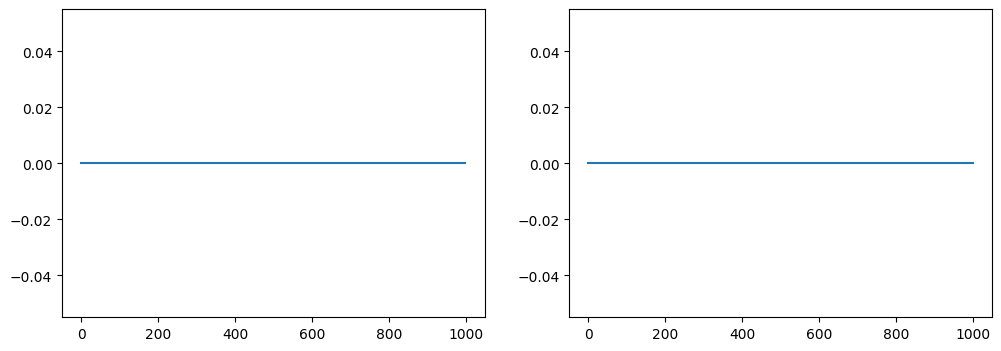

In [439]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history)
axs[1].plot(rounded_history)

In [440]:
z = np.round(mirror_map(particle.reshape(1, -1))).flatten()
z @ A @ z

np.float64(0.0)

In [441]:
capacity

156

In [442]:
z @ weights

np.float64(0.0)

In [377]:
# 18558.00
# 56525.00
# 3752.00
# 50382.00
# 61494.00